In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from joblib import Parallel, delayed

In [2]:
group = 9
student = 3
frame = 12

In [3]:
#Loading data functions
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    return np.array(cv2.imreadmulti(f'./data/sequences/{group}-{student}.tif', flags=cv2.IMREAD_GRAYSCALE)[1])

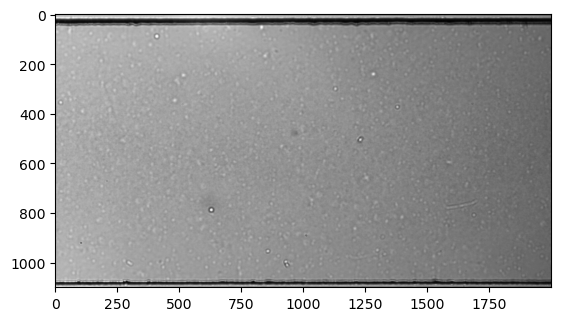

In [4]:
images = load_images(group,student)
masks = np.zeros(images.shape)
back = np.mean(images,axis=0)
plt.imshow(back,cmap='gray');

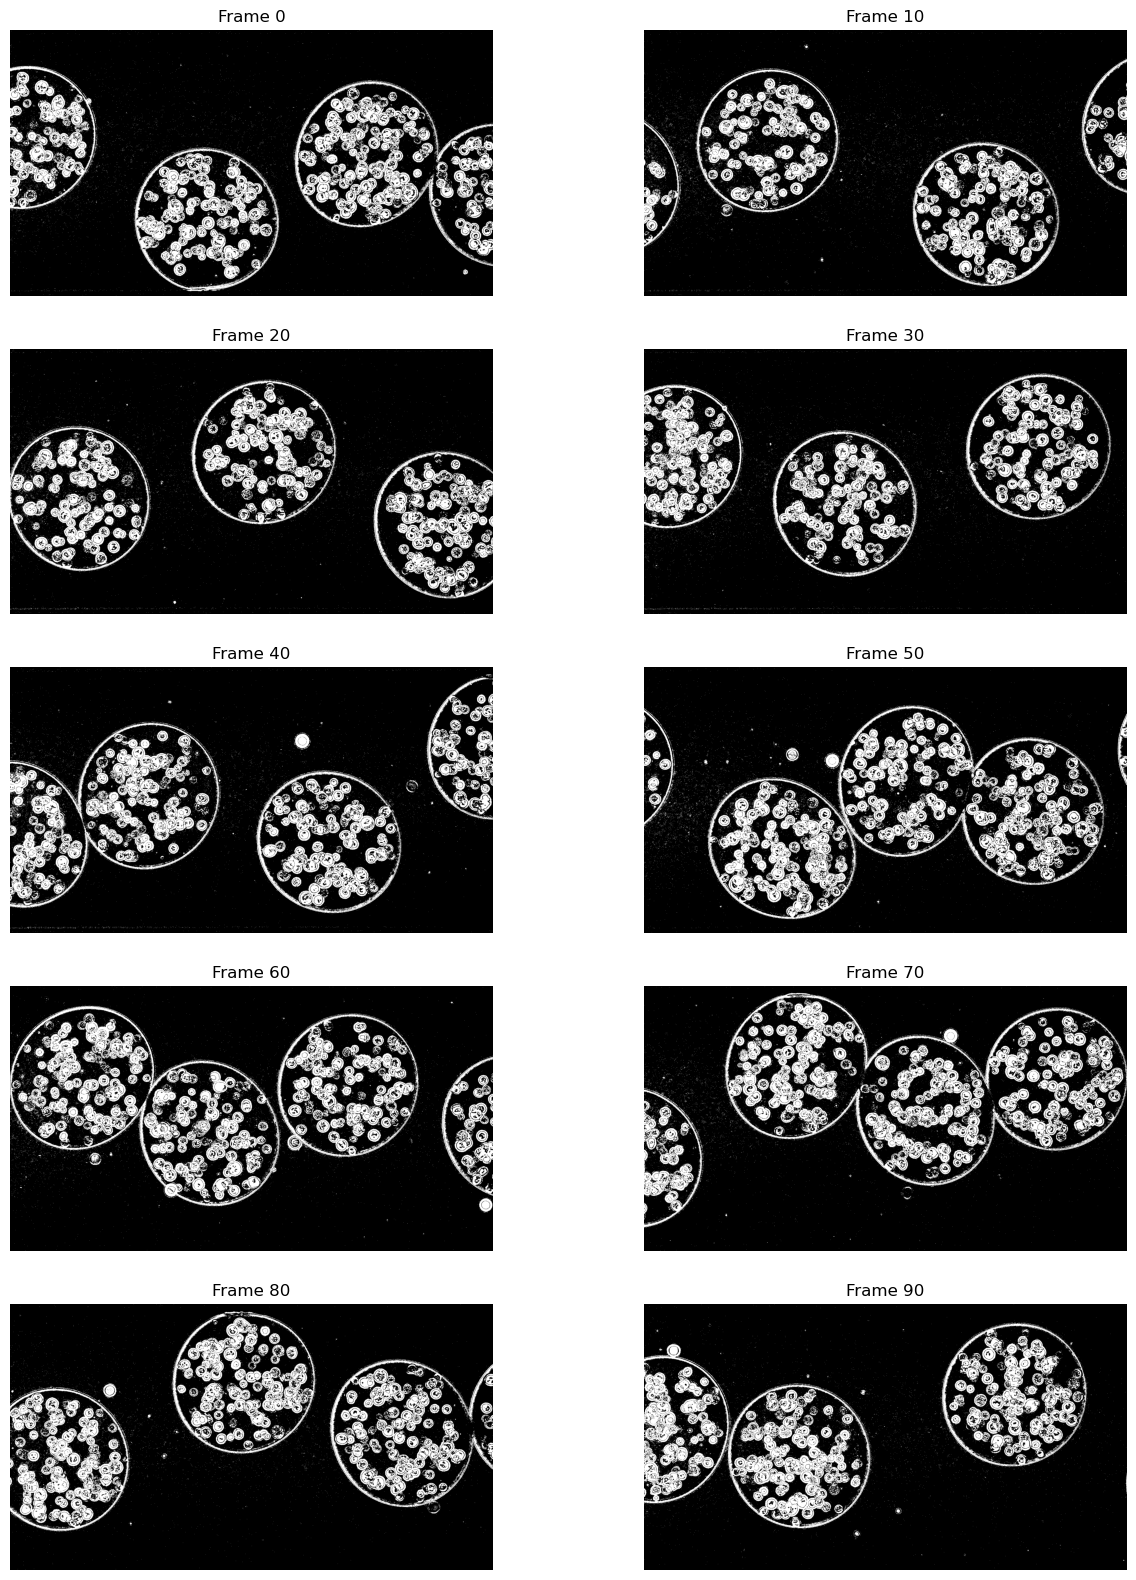

In [5]:
def process_images(images, back):
    def get_mask(image, back):
        return np.abs(image - back) / np.max(image) > 0.1

    masks = Parallel(n_jobs=8)(delayed(get_mask)(image, back) for image in images)
    masks = np.array(masks)
    masks = masks.astype(np.uint8) * 255
    return masks

masks = process_images(images, back)
fig, axs = plt.subplots(5, 2, figsize=(15,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(masks[i*10], cmap='gray')
    ax.set_title(f'Frame {i*10}')
    ax.axis('off')
plt.show()

[[1012, 420, 617, 608], [0, 221, 880, 784]]


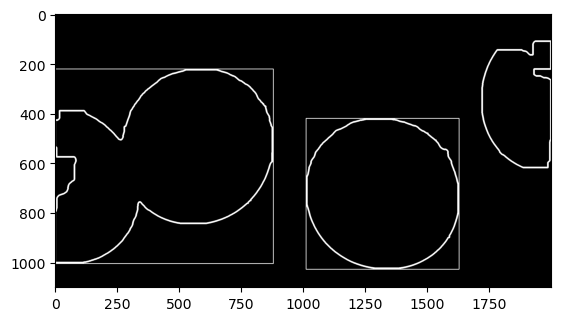

In [9]:
def get_contours(mask):
    def clean_frame(mask):
        image = mask.copy()
        image = cv2.medianBlur(image, 3)

        kernel = np.ones((3,3),np.uint8)
        image = cv2.dilate(image, kernel, iterations=9)

        image = cv2.medianBlur(image, 17)

        contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        image = np.zeros(image.shape)
        bb = []
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(image, [contour], 0, (255), -1)
                x, y, w, h = cv2.boundingRect(contour)
                bb.append((x, y, w, h))
                cv2.rectangle(image, (x, y), (x+w, y+h), (255), 2)

    
        kernel = np.ones((100,100),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        image = np.array(image, dtype=np.uint8)
        return image

    def get_boundaries(mask):
        boundaries = np.zeros(mask.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(boundaries, [contour], 0, (255), 5)
        return np.array(boundaries, dtype=np.uint8)


    def get_bounding_boxes(mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        bb = []
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                x, y, w, h = cv2.boundingRect(contour)
                if w > 400 and h > 400:
                    bb.append([x, y, w, h])

        for i in bb:
            for j in bb:
                x1, y1, w1, h1 = i
                x2, y2, w2, h2 = j
                if x1 < x2 and y1 < y2 and x1+w1 > x2+w2 and y1+h1 > y2+h2:
                    bb.remove(j)
                elif x1 > x2 and y1 > y2 and x1+w1 < x2+w2 and y1+h1 < y2+h2:
                    bb.remove(i)
        return bb
    
    mask = clean_frame(mask)
    mask = get_boundaries(mask)
    bb = get_bounding_boxes(mask)
    return mask, bb
    
contour, bb= get_contours(masks[40])
print(bb)
plt.imshow(contour, cmap='gray')
for x, y, w, h in bb:
    cv2.rectangle(contour, (x, y), (x+w, y+h), (255), 2)
plt.imshow(contour, cmap='gray');
